In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.util.testing as tm
sns.set()
# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

In [21]:
auth.authenticate_user()
print('Authenticated')


Authenticated


In [0]:
project_id='eicudata'

# Extracting features from the eICU dataset for Mortality and los prediction

In [0]:
%%bigquery --project $project_id rawdf
select b.patientunitstayid, gender,age,ethnicity,apacheadmissiondx,admissionheight,admissionweight, temperature,respiratoryrate,heartrate,glucose,fio2,creatinine,ph,hospitaldischargestatus,unitdischargestatus,(unitdischargeoffset-hospitaladmitoffset)/60/24 as ICUstay
from `physionet-data.eicu_crd.apacheapsvar` a
join `physionet-data.eicu_crd.patient` b ON (
a.patientunitstayid =b.patientunitstayid
)
order by uniquepid 

In [24]:
rawdf

,patientunitstayid,gender,age,ethnicity,apacheadmissiondx,admissionheight,admissionweight,temperature,respiratoryrate,heartrate,glucose,fio2,creatinine,ph,hospitaldischargestatus,unitdischargestatus,ICUstay
0,224606,Female,76,Caucasian,"GI perforation/rupture, surgery for",160.0,NaN,36.7,38.0,119,81.0,100.0,1.10,7.280,Alive,Alive,3.031250
1,204602,Female,29,Caucasian,"Cardiovascular medical, other",162.6,88.5,36.5,55.0,138,82.0,-1.0,3.21,-1.000,Alive,Alive,4.201389
2,157016,Female,23,Caucasian,"GI medical, other",162.6,63.5,36.4,45.0,115,82.0,-1.0,0.61,-1.000,Alive,Alive,5.210417
3,211144,Female,67,Caucasian,Aortic valve replacement (isolated),160.0,86.2,36.8,33.0,104,85.0,50.0,0.80,7.380,Alive,Alive,3.893056
4,221005,Female,68,Caucasian,"Complications of previous open-heart surgery, ...",162.6,88.0,36.4,43.0,87,37.0,32.0,-1.00,7.340,Alive,Alive,2.803472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171172,3351785,Male,74,Caucasian,Head only trauma,182.9,75.7,36.8,49.0,50,-1.0,-1.0,-1.00,-1.000,Alive,Alive,1.790278
171173,3340321,Male,44,Caucasian,"Infarction, acute myocardial (MI)",185.4,130.6,36.7,45.0,102,220.0,-1.0,0.91,-1.000,Alive,Alive,2.689583
171174,3345874,Male,55,African American,Rhythm disturbance (conduction defect),190.5,165.9,32.2,37.0,90,254.0,-1.0,2.30,-1.000,Alive,Alive,1.968056
171175,3352628,Male,60,African American,"Apnea-sleep; surgery for (i.e., UPPP - uvulopa...",170.1,120.2,36.3,37.0,114,102.0,50.0,1.00,7.363,Alive,Alive,1.481250


## Finding number of missing or null values -

In [25]:
rawdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171177 entries, 0 to 171176
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   patientunitstayid        171177 non-null  int64  
 1   gender                   171177 non-null  object 
 2   age                      171177 non-null  object 
 3   ethnicity                171177 non-null  object 
 4   apacheadmissiondx        171177 non-null  object 
 5   admissionheight          167853 non-null  float64
 6   admissionweight          164555 non-null  float64
 7   temperature              171177 non-null  float64
 8   respiratoryrate          171177 non-null  float64
 9   heartrate                171177 non-null  int64  
 10  glucose                  171177 non-null  float64
 11  fio2                     171177 non-null  float64
 12  creatinine               171177 non-null  float64
 13  ph                       171177 non-null  float64
 14  hosp

## Statistics of the features for preprocessing - 

In [26]:
rawdf.describe(include='all')

,patientunitstayid,gender,age,ethnicity,apacheadmissiondx,admissionheight,admissionweight,temperature,respiratoryrate,heartrate,glucose,fio2,creatinine,ph,hospitaldischargestatus,unitdischargestatus,ICUstay
count,1.711770e+05,171177,171177,171177,171177,167853.000000,164555.000000,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000,171177,171177,171177.000000
unique,NaN,5,90,7,393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,3,NaN
top,NaN,Male,> 89,Caucasian,"Sepsis, pulmonary",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alive,Alive,NaN
freq,NaN,92468,6084,131319,8427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,153532,161148,NaN
mean,1.747701e+06,NaN,NaN,NaN,NaN,169.266201,83.850422,33.728719,24.784735,98.667993,141.184455,12.794373,0.999311,0.906831,NaN,NaN,4.254612
std,9.988850e+05,NaN,NaN,NaN,NaN,13.845103,27.082294,9.725657,15.301895,33.263814,109.723423,28.329034,1.852455,3.506569,NaN,NaN,6.893154
min,1.411680e+05,NaN,NaN,NaN,NaN,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN,NaN,-0.210417
25%,9.555340e+05,NaN,NaN,NaN,NaN,162.500000,66.000000,36.100000,10.000000,84.000000,85.000000,-1.000000,0.470000,-1.000000,NaN,NaN,1.209028
50%,1.670376e+06,NaN,NaN,NaN,NaN,170.000000,79.900000,36.400000,27.000000,104.000000,115.000000,-1.000000,0.810000,-1.000000,NaN,NaN,2.236111
75%,2.743419e+06,NaN,NaN,NaN,NaN,177.800000,96.800000,36.700000,35.000000,120.000000,187.000000,-1.000000,1.360000,-1.000000,NaN,NaN,4.772222


## Impute missing values for Admission height and Admission weight 

In [0]:
rawdf['admissionheight']=rawdf.admissionheight.fillna(rawdf.admissionheight.median())
rawdf['admissionweight']=rawdf.admissionweight.fillna(rawdf.admissionweight.median())

In [28]:
rawdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171177 entries, 0 to 171176
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   patientunitstayid        171177 non-null  int64  
 1   gender                   171177 non-null  object 
 2   age                      171177 non-null  object 
 3   ethnicity                171177 non-null  object 
 4   apacheadmissiondx        171177 non-null  object 
 5   admissionheight          171177 non-null  float64
 6   admissionweight          171177 non-null  float64
 7   temperature              171177 non-null  float64
 8   respiratoryrate          171177 non-null  float64
 9   heartrate                171177 non-null  int64  
 10  glucose                  171177 non-null  float64
 11  fio2                     171177 non-null  float64
 12  creatinine               171177 non-null  float64
 13  ph                       171177 non-null  float64
 14  hosp

## Convert age values to numeric

In [0]:
rawdf['age'].replace({'> 89': '90'}, inplace=True)
rawdf['age']=rawdf['age'].apply(pd.to_numeric)

In [30]:
rawdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171177 entries, 0 to 171176
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   patientunitstayid        171177 non-null  int64  
 1   gender                   171177 non-null  object 
 2   age                      171109 non-null  float64
 3   ethnicity                171177 non-null  object 
 4   apacheadmissiondx        171177 non-null  object 
 5   admissionheight          171177 non-null  float64
 6   admissionweight          171177 non-null  float64
 7   temperature              171177 non-null  float64
 8   respiratoryrate          171177 non-null  float64
 9   heartrate                171177 non-null  int64  
 10  glucose                  171177 non-null  float64
 11  fio2                     171177 non-null  float64
 12  creatinine               171177 non-null  float64
 13  ph                       171177 non-null  float64
 14  hosp

## Age has some null values. Removing unknown/other category in gender and ethnicity. : 

In [0]:
missing = rawdf[(rawdf['gender'] == '') |(rawdf['gender'] == 'Other')|(rawdf['gender'] == 'Unknown')| (rawdf['ethnicity'] == '')|(rawdf['ethnicity'] == 'Other/Unknown')|(rawdf['unitdischargestatus']=='')|(rawdf['hospitaldischargestatus']=='')].index
rawdf = rawdf.drop(index=missing)
rawdf = rawdf.dropna()

## Checking if we have no more missing or ambiguous values for features

In [33]:
rawdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159592 entries, 0 to 171176
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   patientunitstayid        159592 non-null  int64  
 1   gender                   159592 non-null  object 
 2   age                      159592 non-null  float64
 3   ethnicity                159592 non-null  object 
 4   apacheadmissiondx        159592 non-null  object 
 5   admissionheight          159592 non-null  float64
 6   admissionweight          159592 non-null  float64
 7   temperature              159592 non-null  float64
 8   respiratoryrate          159592 non-null  float64
 9   heartrate                159592 non-null  int64  
 10  glucose                  159592 non-null  float64
 11  fio2                     159592 non-null  float64
 12  creatinine               159592 non-null  float64
 13  ph                       159592 non-null  float64
 14  hosp

In [34]:
rawdf.describe(include='all')

,patientunitstayid,gender,age,ethnicity,apacheadmissiondx,admissionheight,admissionweight,temperature,respiratoryrate,heartrate,glucose,fio2,creatinine,ph,hospitaldischargestatus,unitdischargestatus,ICUstay
count,1.595920e+05,159592,159592.000000,159592,159592,159592.000000,159592.000000,159592.000000,159592.000000,159592.000000,159592.000000,159592.000000,159592.000000,159592.000000,159592,159592,159592.000000
unique,NaN,2,NaN,5,392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,NaN
top,NaN,Male,NaN,Caucasian,"Sepsis, pulmonary",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alive,Alive,NaN
freq,NaN,85985,NaN,130115,7842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144428,150265,NaN
mean,1.743349e+06,NaN,63.169075,NaN,NaN,169.439502,83.884889,33.780006,24.827069,98.714754,141.082306,12.852445,0.999403,0.918279,NaN,NaN,4.247957
std,1.006432e+06,NaN,17.130548,NaN,NaN,13.495273,26.713217,9.633566,15.305676,33.235847,109.700609,28.346292,1.852618,3.513977,NaN,NaN,6.904994
min,1.411680e+05,NaN,0.000000,NaN,NaN,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN,NaN,-0.210417
25%,9.469880e+05,NaN,53.000000,NaN,NaN,162.600000,67.000000,36.100000,10.000000,84.000000,86.000000,-1.000000,0.470000,-1.000000,NaN,NaN,1.213194
50%,1.652000e+06,NaN,65.000000,NaN,NaN,170.000000,79.900000,36.400000,27.000000,104.000000,115.000000,-1.000000,0.820000,-1.000000,NaN,NaN,2.238194
75%,2.749743e+06,NaN,76.000000,NaN,NaN,177.800000,96.100000,36.700000,35.000000,120.000000,187.000000,-1.000000,1.360000,-1.000000,NaN,NaN,4.768750


## Exclusion criteria for mortality prediction
            age <= 18 and age >= 89
            more than 1 ICU stay
            los < 48h

In [36]:
excl = rawdf[(rawdf['age']<= 18) | (rawdf['age']>=89) | (rawdf['ICUstay']<2)].index
rawdf = rawdf.drop(index=excl)
rawdf

,patientunitstayid,gender,age,ethnicity,apacheadmissiondx,admissionheight,admissionweight,temperature,respiratoryrate,heartrate,glucose,fio2,creatinine,ph,hospitaldischargestatus,unitdischargestatus,ICUstay
0,224606,Female,76.0,Caucasian,"GI perforation/rupture, surgery for",160.0,79.9,36.7,38.0,119,81.0,100.0,1.10,7.280,Alive,Alive,3.031250
1,204602,Female,29.0,Caucasian,"Cardiovascular medical, other",162.6,88.5,36.5,55.0,138,82.0,-1.0,3.21,-1.000,Alive,Alive,4.201389
2,157016,Female,23.0,Caucasian,"GI medical, other",162.6,63.5,36.4,45.0,115,82.0,-1.0,0.61,-1.000,Alive,Alive,5.210417
3,211144,Female,67.0,Caucasian,Aortic valve replacement (isolated),160.0,86.2,36.8,33.0,104,85.0,50.0,0.80,7.380,Alive,Alive,3.893056
4,221005,Female,68.0,Caucasian,"Complications of previous open-heart surgery, ...",162.6,88.0,36.4,43.0,87,37.0,32.0,-1.00,7.340,Alive,Alive,2.803472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171169,3351729,Male,64.0,African American,"CABG alone, coronary artery bypass grafting",182.9,112.5,36.1,41.0,91,82.0,100.0,1.19,7.356,Alive,Alive,6.891667
171170,3340416,Male,64.0,Caucasian,"CABG alone, coronary artery bypass grafting",193.0,109.1,35.8,5.0,91,181.0,100.0,0.60,7.315,Alive,Alive,3.617361
171171,3329614,Male,71.0,African American,"Hemorrhage/hematoma, intracranial",188.0,90.7,36.7,50.0,109,97.0,-1.0,2.52,-1.000,Expired,Alive,3.704167
171173,3340321,Male,44.0,Caucasian,"Infarction, acute myocardial (MI)",185.4,130.6,36.7,45.0,102,220.0,-1.0,0.91,-1.000,Alive,Alive,2.689583


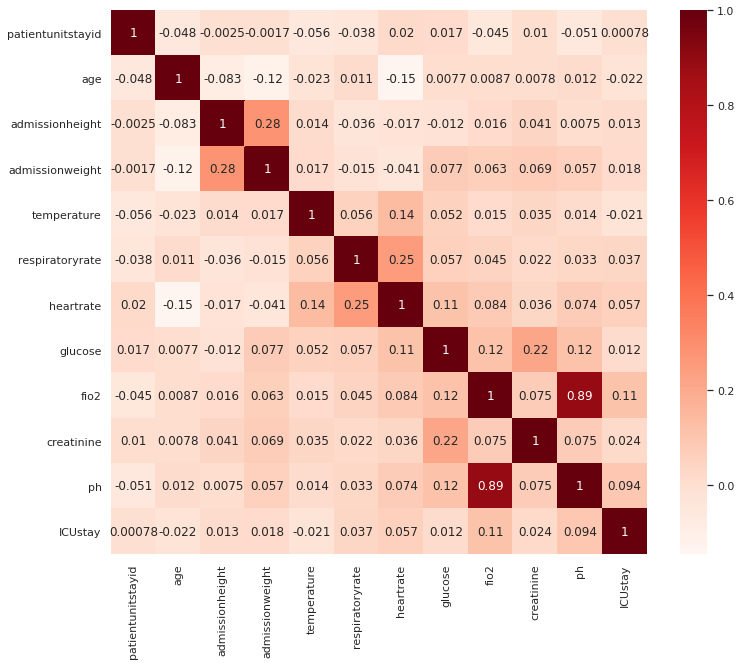

In [37]:
plt.figure(figsize=(12,10))
cor = rawdf.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()